#CMGF-EKF Evaluation for MLP Training

Author: Peter Chang([@petergchang](https://github.com/petergchang))

##0. Imports

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    from ssm_jax.cond_moments_gaussian_filter.inference import *
    from ssm_jax.cond_moments_gaussian_filter.containers import *
    import flax.linen as nn
except ModuleNotFoundError:
    print('installing ssm_jax')
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    %pip install -qq flax
    from ssm_jax.cond_moments_gaussian_filter.inference import *
    from ssm_jax.cond_moments_gaussian_filter.containers import *
    import flax.linen as nn

installing ssm_jax
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 180 kB 4.8 MB/s 
     |████████████████████████████████| 145 kB 45.1 MB/s 
     |████████████████████████████████| 114 kB 11.7 MB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
     |████████████████████████████████| 128 kB 46.7 MB/s 
     |████████████████████████████████| 217 kB 54.4 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 


In [3]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
from jax import lax
from jax import vmap
from jax.tree_util import tree_map, tree_reduce, tree_leaves
from jax import jacfwd
from jax.scipy.linalg import block_diag

#1. MLP Definition

In [4]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [5]:
def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

In [6]:
# Generate spiral dataset
# Adapted from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
def generate_spiral_dataset(key=0, num_per_class=250, zero_var=1., one_var=1., shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, key3, key4 = jr.split(key, 4)

    theta = jnp.sqrt(jr.uniform(key1, shape=(num_per_class,))) * 2*jnp.pi
    r = 2*theta + jnp.pi
    generate_data = lambda theta, r: jnp.array([jnp.cos(theta)*r, jnp.sin(theta)*r]).T

    # Data for output zero
    zero_input = generate_data(theta, r) + zero_var * jr.normal(key2, shape=(num_per_class, 2))
    zero_output = jnp.zeros((num_per_class, 1,))

    # Data for output one
    one_input = generate_data(theta, -r) + one_var * jr.normal(key3, shape=(num_per_class, 2))
    one_output = jnp.ones((num_per_class, 1,))

    # Stack the inputs and standardize
    input = jnp.concatenate([zero_input, one_input])
    input = (input - input.mean(axis=0)) / input.std(axis=0)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros(num_per_class), jnp.ones(num_per_class)])

    if shuffle:
        idx = jr.permutation(key4, jnp.arange(num_per_class * 2))
        input, output = input[idx], output[idx]

    return input, output

#2. Decouple Helper Functions

In [7]:
from functools import partial

def decouple_flat_params(model_dims):
    assert len(model_dims) > 1
    decoupled_params_idx = []
    curr_idx = 0
    for layer in range(1, len(model_dims)):
        # Number of parameter elements corresponding to current layer
        num_prev, num_curr = model_dims[layer-1], model_dims[layer] # Number of nodes in prev, curr layer
        num_bias_params = num_curr
        num_weight_params = num_prev * num_curr
        num_params_curr_layer = num_bias_params + num_weight_params
        
        # Range of indices in flattened params array corresponding to current layer
        idx_range = jnp.arange(curr_idx, curr_idx + num_params_curr_layer)
        
        # Append list of indices for each node in current layer
        decoupled_params_idx += [jnp.array([idx_range[i + num_curr * j] for j in range(num_prev + 1)]) for i in range(num_curr)]
        
        curr_idx += num_params_curr_layer

    # Function to decouple parameters by node
    decouple_fn = jax.jit(lambda params: {i: params[idx] for i, idx in enumerate(decoupled_params_idx)})

    # Function to decouple Jacobians by node
    decouple_jac_fn = jax.jit(lambda jac: {i: jac[:,idx] for i, idx in enumerate(decoupled_params_idx)})

    # Set to tuple to avoid non-hashable type error when using lists/DeviceArrays
    params_sizes = tuple([0] + [len(node_params) for node_params in decoupled_params_idx])
    diag_idx = jnp.cumsum(jnp.array(params_sizes))

    # Function to separate parameter covariance matrix by node
    @partial(jax.jit, static_argnums=(2,))
    def decouple_cov_fn(cov, diag_idx, params_sizes):
        return {i: lax.dynamic_slice(cov, (diag_idx[i], diag_idx[i]), (params_sizes[i+1], params_sizes[i+1])) for i in range(0, len(diag_idx)-1)}
    decouple_cov_fn = partial(decouple_cov_fn, diag_idx=diag_idx, params_sizes=params_sizes)
    recouple_cov_fn = jax.jit(lambda covs: block_diag(*tree_leaves(covs)))
    
    # Function to recouple decoupled params list
    @jax.jit
    def recouple_fn(decoupled_params):
        decoupled_params_list = tree_leaves(decoupled_params)
        recoupled_params_list = []
        curr_idx = 0
        for layer in range(1, len(model_dims)):
            # Flatten params sublist corresponding to each layer
            recoupled_params_list.append(jnp.ravel(jnp.array(decoupled_params_list[curr_idx:curr_idx + model_dims[layer]]), order='F'))
            curr_idx += model_dims[layer]
            
        return jnp.concatenate(recoupled_params_list)
    
    return decouple_fn, recouple_fn, decouple_cov_fn, recouple_cov_fn, decouple_jac_fn

In [8]:
def generate_decouple_params(model_dims):
    decouple_params = DecoupleParams(
        decouple_fn = decouple_flat_params(model_dims)[0],
        recouple_fn = decouple_flat_params(model_dims)[1],
        decouple_cov_fn = decouple_flat_params(model_dims)[2],
        recouple_cov_fn = decouple_flat_params(model_dims)[3],
        decouple_jac_fn = decouple_flat_params(model_dims)[4]
    )
    return decouple_params

#3. Decoupled CMGF-EKF-MLP

In [9]:
from jax.scipy.linalg import block_diag

In [10]:
# Helper functions
_get_params = lambda x, dim, t: x[t] if x.ndim == dim + 1 else x
_process_fn = lambda f, u: (lambda x, y: f(x)) if u is None else f
_process_input = lambda x, y: jnp.zeros((y,)) if x is None else x

In [11]:
@chex.dataclass
class DecoupleParams:
    decouple_fn: Callable
    recouple_fn: Callable
    decouple_cov_fn: Callable
    recouple_cov_fn: Callable
    decouple_jac_fn: Callable

In [12]:
from functools import partial

_jacfwd_2d = lambda f, x: jnp.atleast_2d(jacfwd(f)(x))

def _decoupled_condition_on(m, P, decouple_params, y_cond_mean, y_cond_cov, u, y, num_iter):
    m_Y = lambda x: y_cond_mean(x, u)
    Cov_Y = lambda x: y_cond_cov(x, u)

    decouple_fn, recouple_fn = decouple_params.decouple_fn, decouple_params.recouple_fn
    decouple_cov_fn, recouple_cov_fn = decouple_params.decouple_cov_fn, decouple_params.recouple_cov_fn
    decouple_jac_fn = decouple_params.decouple_jac_fn
    
    def _step(carry, _):
        prior_means, prior_covs = carry
        prior_mean = recouple_fn(prior_means)
        yhat = jnp.atleast_1d(m_Y(prior_mean))

        # Compute and decouple Jacobian
        H = _jacfwd_2d(m_Y, prior_mean)
        Hs = decouple_jac_fn(H)

        # Compute intermediate parameters
        S = jnp.atleast_1d(Cov_Y(prior_mean)) + \
            tree_reduce(lambda a, b: a+b, tree_map(lambda hh, pp: hh @ pp @ hh.T, Hs, Ps))
        log_likelihood = MVN(yhat, S).log_prob(jnp.atleast_1d(y))
        Ks = tree_map(lambda hh, pp: jnp.linalg.solve(S, hh @ pp.T).T, Hs, Ps)

        # Compute posterior parameters
        posterior_means = tree_map(lambda mm, dd: mm + dd, prior_means, 
                                   tree_map(lambda kk: kk @ (y - yhat), Ks))
        posterior_covs = tree_map(lambda pp, kk, hh: pp - kk @ hh @ pp, prior_covs, Ks, Hs)
        return (posterior_means, posterior_covs), log_likelihood

    # Decouple parameters before iteration
    ms, Ps = decouple_fn(m), decouple_cov_fn(P)
    carry = (ms, Ps)
    # Iterate re-linearization over posterior mean and covariance
    (mus_cond, Sigmas_cond), lls = lax.scan(_step, carry, jnp.arange(num_iter))
    mu_cond, Sigma_cond = recouple_fn(mus_cond), recouple_cov_fn(Sigmas_cond)

    return lls[0], mu_cond, Sigma_cond

In [13]:
def _predict(m, P, f, Q, u, g_ev, g_cov):
    dynamics_fn = lambda x: f(x, u)
    identity_fn = lambda x: x
    mu_pred = g_ev(dynamics_fn, m, P)
    Sigma_pred = g_cov(dynamics_fn, dynamics_fn, m, P) + Q
    cross_pred = g_cov(identity_fn, dynamics_fn, m, P)
    return mu_pred, Sigma_pred, cross_pred

In [14]:
def decoupled_extended_conditional_moments_gaussian_filter(params, decouple_params, emissions, num_iter=1, inputs=None):
    num_timesteps = len(emissions)

    # Process dynamics function and conditional emission moments to take in control inputs
    f = params.dynamics_function
    m_Y, Cov_Y = params.emission_mean_function, params.emission_cov_function
    f, m_Y, Cov_Y  = (_process_fn(fn, inputs) for fn in (f, m_Y, Cov_Y))
    inputs = _process_input(inputs, num_timesteps)

    # Gaussian expectation value function
    g_ev = params.gaussian_expectation
    g_cov = params.gaussian_cross_covariance

    def _step(carry, t):
        ll, pred_mean, pred_cov = carry

        # Get parameters and inputs for time index t
        Q = _get_params(params.dynamics_covariance, 2, t)
        u = inputs[t]
        y = emissions[t]

        # Condition on the emission
        log_likelihood, filtered_mean, filtered_cov = _decoupled_condition_on(pred_mean, pred_cov, decouple_params, 
                                                                              m_Y, Cov_Y, u, y, num_iter)
        ll += log_likelihood

        # Predict the next state
        pred_mean, pred_cov, _ = _predict(filtered_mean, filtered_cov, f, Q, u, g_ev, g_cov)

        return (ll, pred_mean, pred_cov), (filtered_mean, filtered_cov)

    # Run the general linearization filter
    carry = (0.0, params.initial_mean, params.initial_covariance)
    (ll, _, _), (filtered_means, filtered_covs) = lax.scan(_step, carry, jnp.arange(num_timesteps))
    return GSSMPosterior(marginal_loglik=ll, filtered_means=filtered_means, filtered_covariances=filtered_covs)


# Experiment

In [17]:
# Generate data
input, output = generate_spiral_dataset(num_per_class=2500)

# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [15, 15, 15, 15], 1
model_dims = [input_dim, *hidden_dims, output_dim]


model, flat_params, unflatten_fn, apply_fn = get_mlp_flattened_params(model_dims)

# Some model parameters and helper funciton
state_dim, emission_dim = flat_params.size, output_dim
sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x))

cmgf_ekf_params = EKFParams(
    initial_mean=flat_params,
    initial_covariance=jnp.eye(state_dim),
    dynamics_function=lambda w, x: w,
    dynamics_covariance=jnp.eye(state_dim) * 1e-4,
    emission_mean_function = lambda w, x: sigmoid_fn(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
)

decouple_params = generate_decouple_params(model_dims)

In [ ]:
w_means = decoupled_extended_conditional_moments_gaussian_filter(cmgf_ekf_params, decouple_params, output, inputs=input).filtered_means

In [197]:
# Define grid limits
xmin, ymin = input.min(axis=0) - 0.1
xmax, ymax = input.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

In [198]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

In [199]:
# 'binary=True' indicates rounding probabilities to binary outputs
def posterior_predictive_grid(grid, mean, apply, binary=False):
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

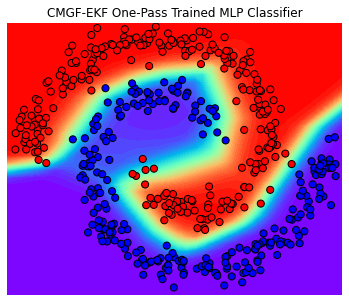

In [200]:
# Evaluate the trained MLP on input_grid
Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)

# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, input, output, title, input_grid, Z);

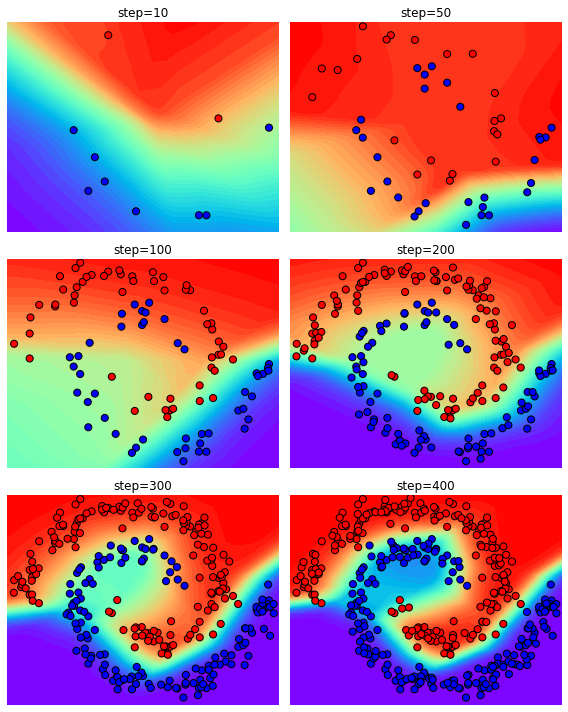

In [201]:
intermediate_steps = [9, 49, 99, 199, 299, 399]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid, w_means[step], sigmoid_fn)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, input[:step+1], output[:step+1], title, input_grid, Zi)
plt.tight_layout()